

# **VGG16**



In [1]:
!pip install seaborn

     |████████████████████████████████| 292 kB 2.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
#import cv2
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt                                           
import tensorflow as tf    
from sklearn import metrics
from tqdm import tqdm
import pickle
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten


In [1]:
pip install seaborn

     |████████████████████████████████| 292 kB 54 kB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd

def create_dataframe_from_folder(folder_path, class_label):
    """
    Creates a DataFrame from the image paths in the specified folder.

    Parameters:
        folder_path (str): The path to the folder containing images.
        class_label (str): The label to assign to the images in the DataFrame.

    Returns:
        pd.DataFrame: The DataFrame containing image paths and class labels.
    """
    image_paths = [img_path for img_path in os.listdir(folder_path) if img_path.endswith('.jpeg')]
    class_labels = [class_label] * len(image_paths)
    df = pd.DataFrame({'path': image_paths, 'label': class_labels})
    return df

# Assuming you have defined 'training_data_path' as the path to the main training data folder
training_data_path = 'OCT_dgx/OCT2017/train'

# Create DataFrame for the "NORMAL" class
CNV = create_dataframe_from_folder(os.path.join(training_data_path, 'CNV'), 'CNV')


DME = create_dataframe_from_folder(os.path.join(training_data_path, 'DME'), 'DME')

DRUSEN = create_dataframe_from_folder(os.path.join(training_data_path, 'DRUSEN'), 'DRSEN')

NORMAL = create_dataframe_from_folder(os.path.join(training_data_path, 'NORMAL'), 'NORMAL')

path_label_df = pd.concat([CNV,DME,DRUSEN,NORMAL])
path_label_df.index = np.arange(83484)


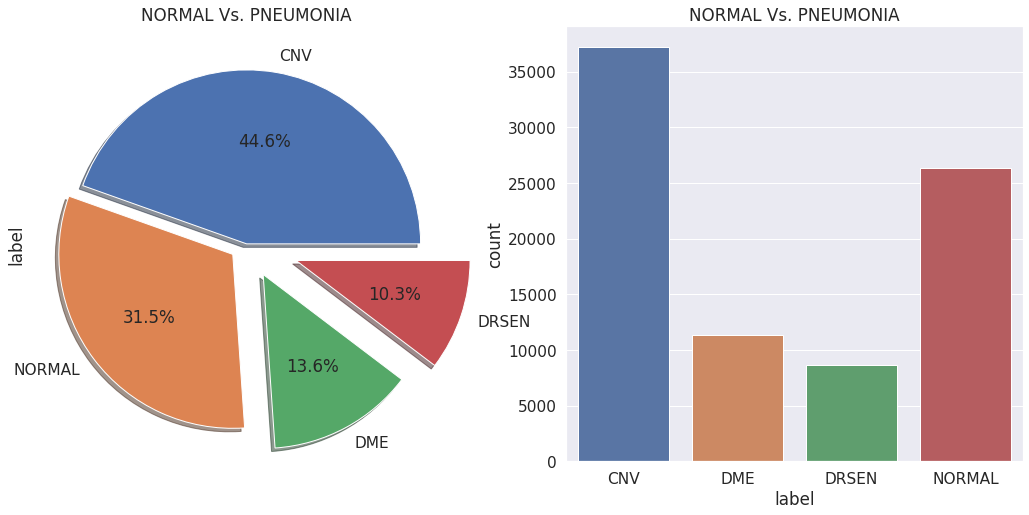

In [4]:
import seaborn as sns
f,ax=plt.subplots(1,2,figsize=(18,8))
path_label_df['label'].value_counts().plot.pie(explode=[0,0.1,0.2,0.3],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('NORMAL Vs. PNEUMONIA')
sns.countplot(x=path_label_df['label'])
ax[1].set_title('NORMAL Vs. PNEUMONIA')
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
pwd

'/workspace/data'

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = 'OCT_dgx/OCT2017/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 66788 images belonging to 4 classes.


In [7]:
test_dataset = test_datagen.flow_from_directory(directory = 'OCT_dgx/OCT2017/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1003 images belonging to 4 classes.


In [8]:
# create an instance of VGG16 with pre-trained weights
IMAGE_SIZE = (224, 224)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 5s 0us/step


In [9]:
# model = Model(inputs=resnet.input, outputs=prediction)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
x = base_model.output
# x = GlobalAveragePooling2D()(x)
#x = vgg.output
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(base_model.output)

predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)



In [10]:
# freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [11]:
from tensorflow.keras.optimizers import Adam
# compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(loss='binary_crossentropy',
# optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
# metrics='accuracy')

In [12]:
history=model.fit(train_dataset,
                        validation_data=test_dataset,validation_steps=8,
                        epochs = 50,verbose = 1)

Epoch 1/50
2088/2088 [==============================] - 930s 445ms/step - loss: 0.6480 - acc: 0.7682 - val_loss: 0.4713 - val_acc: 0.7969
Epoch 2/50
2088/2088 [==============================] - 922s 442ms/step - loss: 0.5066 - acc: 0.8173 - val_loss: 0.3245 - val_acc: 0.8945
Epoch 3/50
2088/2088 [==============================] - 924s 443ms/step - loss: 0.4715 - acc: 0.8305 - val_loss: 0.3134 - val_acc: 0.8750
Epoch 4/50
2088/2088 [==============================] - 925s 443ms/step - loss: 0.4532 - acc: 0.8360 - val_loss: 0.3207 - val_acc: 0.8672
Epoch 5/50
2088/2088 [==============================] - 920s 441ms/step - loss: 0.4408 - acc: 0.8414 - val_loss: 0.2996 - val_acc: 0.8906
Epoch 6/50
2088/2088 [==============================] - 918s 440ms/step - loss: 0.4296 - acc: 0.8447 - val_loss: 0.2715 - val_acc: 0.9023
Epoch 7/50
2088/2088 [==============================] - 920s 440ms/step - loss: 0.4226 - acc: 0.8465 - val_loss: 0.2315 - val_acc: 0.9297
Epoch 8/50
2088/2088 [============

In [13]:

import pandas as pd

df=pd.DataFrame(history.history)
df  

,loss,acc,val_loss,val_acc
0,0.647987,0.768192,0.471291,0.796875
1,0.506726,0.817288,0.324531,0.894531
2,0.471383,0.830479,0.313440,0.875000
3,0.453326,0.835974,0.320687,0.867188
4,0.440830,0.841379,0.299614,0.890625
5,0.429650,0.844748,0.271503,0.902344
6,0.422523,0.846529,0.231504,0.929688
7,0.416993,0.849389,0.359502,0.828125
8,0.412075,0.850467,0.300116,0.859375
9,0.406678,0.854180,0.301705,0.863281


In [14]:
df.to_csv('vgg.csv')

In [16]:
df['acc'].max(),df['acc'].min()

(0.8730310797691345, 0.7681918740272522)

In [16]:
# df['val_accuracy'].max(),df['val_accuracy'].min()

In [26]:
df['loss'].max(),df['loss'].min()

(0.930461677597077, 0.42166008204337746)

In [15]:
preds = model.predict(test_dataset,verbose=1)

32/32 [==============================] - 5s 169ms/step


In [17]:
test_acc,loss = model.evaluate(test_dataset)

32/32 [==============================] - 4s 110ms/step - loss: 0.2744 - acc: 0.8923


In [30]:
preds = model.predict(test_dataset)

In [48]:
test_labels = test_dataset.classes


In [33]:

# Extract the true labels by iterating through the test dataset
true_labels = []
for i in range(len(test_dataset)):
    _, labels = test_dataset[i]
    true_labels.extend(np.argmax(labels, axis=1))

In [47]:
print(true_labels)

[0 0 0 ... 3 3 3]


In [50]:
acc = accuracy_score(true_labels, np.argmax(preds, axis=1)) * 100
acc

26.22133599202393

Accuracy: 23.43%
Confusion Matrix:
[[75 62 53 60]
 [86 46 48 70]
 [72 53 45 80]
 [84 50 50 69]]


In [40]:
# Get the true labels from the test dataset
true_labels = test_dataset.classes

# Predict on the test dataset
preds = model.predict(test_dataset)

# Get class labels
class_labels = list(test_dataset.class_indices.keys())

# Generate a classification report
classification_rep = classification_report(true_labels, np.argmax(preds, axis=1), target_names=class_labels)

# Print the classification report
print(classification_rep)

              precision    recall  f1-score   support

         CNV       0.26      0.33      0.29       250
         DME       0.30      0.25      0.27       250
      DRUSEN       0.25      0.20      0.22       250
      NORMAL       0.25      0.27      0.26       253

    accuracy                           0.26      1003
   macro avg       0.26      0.26      0.26      1003
weighted avg       0.26      0.26      0.26      1003



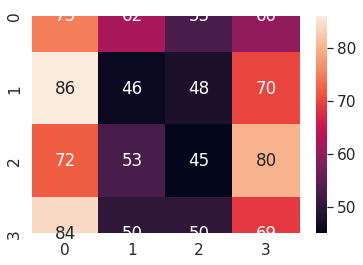

In [41]:
import seaborn as sns
sns.heatmap(cm, annot=True)

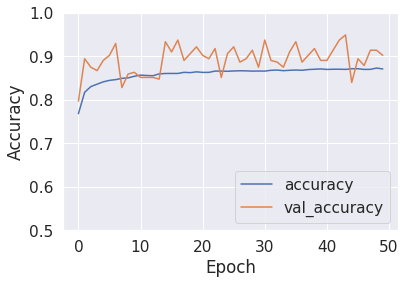

In [25]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

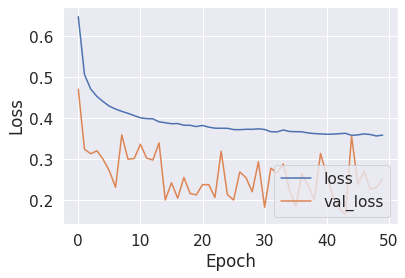

In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

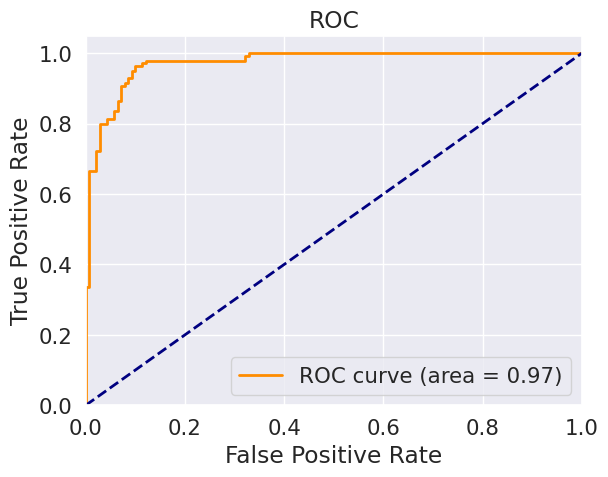

In [26]:
fpr, tpr, _ = roc_curve(test_labels, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()